In [ ]:
from __future__ import division, print_function
%matplotlib inline

# Image analysis fundamentals 4: segmentation


Segmentation is the division of an image into "meaningful" regions. If you've seen The Terminator, you've seen image segmentation:

![Terminator vision](images/terminator-vision.png)

In `scikit-image`, you can find segmentation functions in the `segmentation` package (oddly enough), with one exception: the `watershed` function is in `morphology`, because it's a bit of both. We'll use two algorithms, SLIC and watershed, and just discuss the rest, and applications of each.

There are two kinds of segmentation: *contrast-based* and *boundary-based*. The first is used when the regions of the image you are trying to divide have different characteristics, such as a red flower on a green background. The second is used when you want to segment an image in which borders between objects are prominent, but objects themselves are not very distinct. For example, a pile of oranges.

## Image types: contrast

SLIC is a segmentation algorithm of the first kind: it's clustering pixels in both space and color. (Simple Linear Iterative Clustering.) Therefore, regions of space that are similar in color will end up in the same segment.

Let's try to segment this image:

![Spice, by Clyde
Robinson](images/spice_1.jpg)

(Photo by Flickr user Clyde Robinson, used under CC-BY 2.0 license.)

The SLIC function takes two parameters: the desired number of segments, and the "compactness", which is the relative weighting of the space and color dimensions. The higher the compactness, the more "square" the returned segments.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

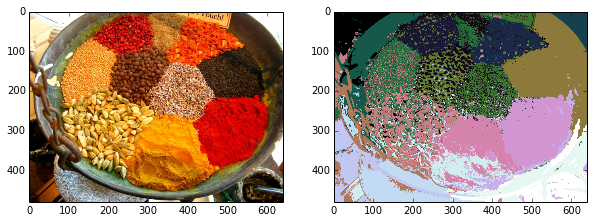

In [5]:
import skdemo
plt.rcParams['image.cmap'] = 'cubehelix'
from skimage import io, segmentation as seg, color
url = 'images/spice_1.jpg'
image = io.imread(url)
labels = seg.slic(image, n_segments=18, compactness=10)
skdemo.imshow_all(image, labels.astype(float) / labels.max())

We can try to create a nicer visualization for `labels`: each segment will be represented by its average color.

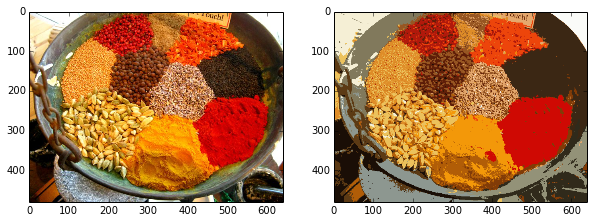

In [6]:
def mean_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        indices = np.nonzero(labels == label)
        out[indices] = np.mean(image[indices], axis=0)
    return out

skdemo.imshow_all(image, mean_color(image, labels))

Notice that some spices are broken up into "light" and "dark" parts. We have multiple parameters to control this:

- `enforce_connectivity`: Do some post-processing so that small regions get merged to adjacent big regions.

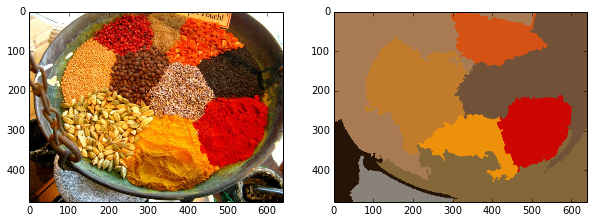

In [7]:
labels = seg.slic(image, n_segments=18, compactness=10,
                  enforce_connectivity=True)
label_image = mean_color(image, labels)
skdemo.imshow_all(image, label_image)

Yikes! It looks like a little too much merging went on! This is because of the intertwining of the labels. One way to avoid this is to blur the image before segmentation. Because this is so useful, a Gaussian blur is included in SLIC: just pass in the `sigma` parameter:

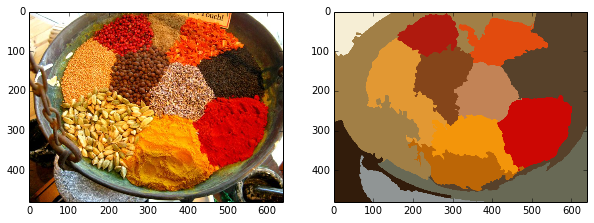

In [8]:
labels = seg.slic(image, n_segments=18, compactness=10,
                  sigma=2, enforce_connectivity=True)
label_image = mean_color(image, labels)
skdemo.imshow_all(image, label_image)

Getting there! But it looks like some regions are merged together. We can alleviate this by increasing the number of segments:

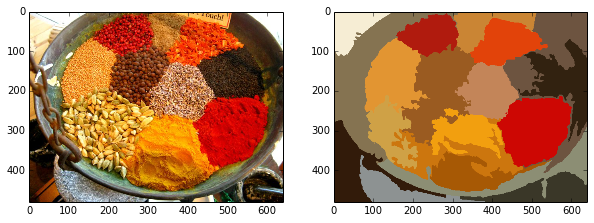

In [9]:
labels = seg.slic(image, n_segments=24, compactness=10,
                  sigma=2, enforce_connectivity=True)
label_image = mean_color(image, labels)
skdemo.imshow_all(image, label_image)

That's looking pretty good! Some regions are still too squiggly though... Let's try jacking up the compactness:

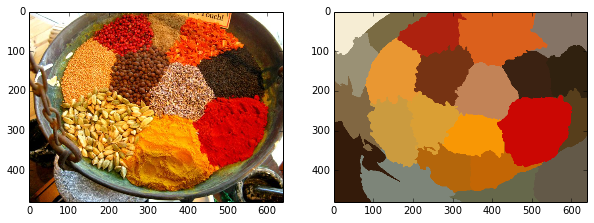

In [10]:
labels = seg.slic(image, n_segments=24, compactness=40,
                  sigma=2, enforce_connectivity=True)
label_image = mean_color(image, labels)
skdemo.imshow_all(image, label_image)

**Exercise**: Write an interactive tool to explore the SLIC parameter space. Recall that the function signature is as follows:

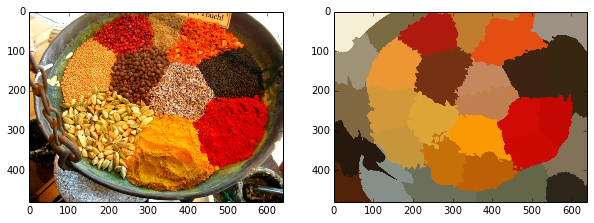

In [14]:
def islic(*args, **kwargs):
    s = seg.slic(image, *args, **kwargs)
    c = mean_color(image, s)
    skdemo.imshow_all(image, c)

from IPython.html import widgets
w = widgets.interactive(islic, compactness=(5, 200, 10),
                        n_segments=(25, 100, 5),
                        sigma=(0., 5., 0.1),
                        enforce_connectivity=True)
w.msg_throttle = 1
w

**Exercise**: Try segmenting the following image with a modification to the same tool:

![Spices](images/spices.jpg)

"Spices" photo by Flickr user Riyaad Minty.
https://www.flickr.com/photos/riym/3326786046
Used under the Creative Commons CC-BY 2.0 license.

Note: this image is more challenging to segment because the color regions are different from one part of the image to the other. Try the `slic_zero` parameter in combination with different values for `n_segments`.

In [ ]:
url2 = 'images/spices.jpg'

## Image types: boundary images

Often, the contrast between regions is not sufficient to distinguish them, but there is a clear boundary between the two. Using an edge detector on these images, followed by a *watershed*, often gives very good segmentation. For example, look at the output of the Sobel filter on the coins image:

<matplotlib.colorbar.Colorbar instance at 0x10a4a13f8>

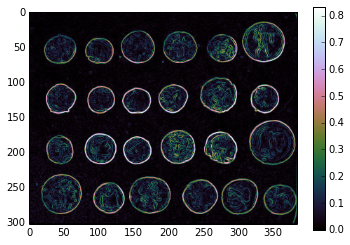

In [16]:
from skimage import data, filter as filters
from matplotlib import pyplot as plt, cm
coins = data.coins()
edges = filters.sobel(coins)
plt.imshow(edges)
plt.colorbar()

The *watershed algorithm* finds the regions between these edges. It does so by envisioning the pixel intensity as height on a topographic map. It then "floods" the map from the bottom up, starting from seed points. These flood areas are called "watershed basins" and when they meet, they form the image segmentation.

Let's look at a one-dimensional example:

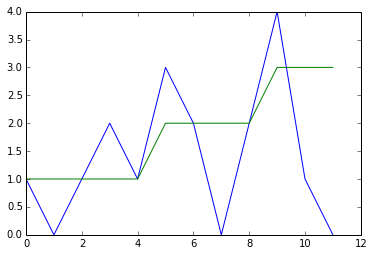

In [17]:
from skimage.morphology import watershed
from scipy import ndimage as nd
image = np.array([[1, 0, 1, 2, 1, 3, 2, 0, 2, 4, 1, 0]])
seeds = nd.label(image == 0)[0]
plt.plot(image[0])
plt.plot(watershed(image, seeds)[0])

Let's find some seeds for `coins`. First, we compute the *distance transform* of a thresholded version of `edges`:

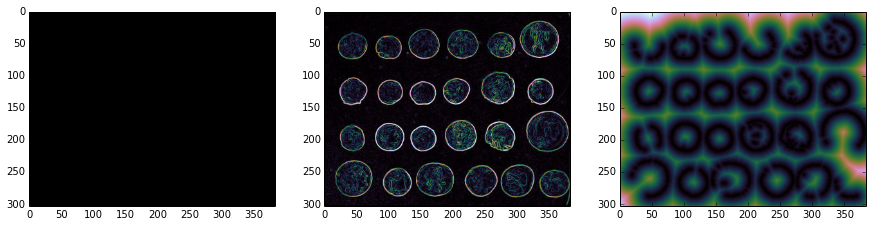

In [20]:
from scipy import ndimage as nd
threshold = 0.4
distance_from_edge = nd.distance_transform_edt(edges < threshold)
skdemo.imshow_all(coins / coins.max(),
                  edges / edges.max(),
                  distance_from_edge / distance_from_edge.max())

Then, we find the *peaks* in that image, which will act as the seeds, being as far away from the peaks as possible.

In [21]:
from skimage import feature
peaks = feature.peak_local_max(distance_from_edge)
peaks_image = np.zeros(coins.shape, np.bool)
peaks_image[tuple(np.transpose(peaks))] = True
seeds, num_seeds = nd.label(peaks_image)

We are now ready to perform the watershed:

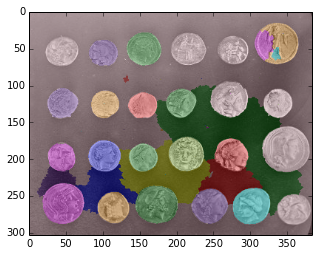

In [22]:
ws = watershed(edges, seeds)
from skimage import color
plt.imshow(color.label2rgb(ws, coins))

**Exercise**: We can see that watershed gives a very good segmentation, but some coins are missing. Why? Can you suggest better seed points for the watershed operation?

In [ ]:
# some ideas:
#  - Gaussian smoothing with broad kernel, followed by
#    `peak_local_max` as above
#  - Canny edge detector, followed by distance transform

# Discussion

Watershed and SLIC are too simple to be used as final segmentation outputs. In fact, their output is often called a *superpixel*, a kind of minimal segment. These are then used for further processing. Downstream processing methods are slated to be added to scikit-image in the next version. See Vighnesh Birodkar's [GSoC project](http://www.google-melange.com/gsoc/proposal/public/google/gsoc2014/vighneshbirodkar/5870670537818112) and his recent (and excellent) [PR](https://github.com/scikit-image/scikit-image/pull/1031). These are beyond the scope of this tutorial but come chat to me after if you are interested in segmentation!